In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, resnet50
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import random
import torchvision.transforms.functional as TF
from skimage.restoration import unsupervised_wiener
from sklearn.metrics import roc_auc_score, roc_curve
data_pth= r"PATH_to_File"
train_pth= os.path.join(data_pth,os.listdir(data_pth)[1])
num_class= 2
classes= os.listdir(train_pth)[1:]

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device:{device}")

Device:cuda


In [3]:
def prep_data(train_pth,classes):
    data= []
    no_substr_pth=os.path.join(train_pth, classes[0])
    for i , j in enumerate(classes[1:]):
        curr_dir= os.path.join(train_pth, j)
        for k in os.listdir(curr_dir):
            data.append((os.path.join(curr_dir, k), os.path.join(no_substr_pth, k), i))
    return data
data= prep_data(train_pth, classes)

In [4]:
def normalize(x):
    x_max, x_min= torch.max(x),torch.min(x)
    return (x- x_min)/(x_max-x_min) 


class dataset:
    def __init__(self, path):
        self.img_pth = path
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()
        ])
        self.psf_guess=np.ones((5, 5)) / 25
    def __len__(self):
        return len(self.img_pth)
    def __getitem__(self, idx):
        img_pth, no_substr_pth, label = self.img_pth[idx]
        no_substr_img= np.load(no_substr_pth)
        img  = np.load(img_pth)
        img, no_substr_img= (img+1)*127.5,(no_substr_img+1)*127.5
        residual = img- no_substr_img
        residual= residual.squeeze(0)
        deblurred_image, _ = unsupervised_wiener(residual, self.psf_guess)
        residual= torch.tensor(deblurred_image, dtype=torch.float32)
        residual= residual.unsqueeze(0)
        residual= self.transform(residual)
        return residual, label

In [5]:
batch_size= 64
train_data= dataset(data)
train_loader= DataLoader(train_data, batch_size= batch_size,shuffle=True)

In [6]:
class CustomResNet50(nn.Module):
    def __init__(self):
        super(CustomResNet50, self).__init__()
        self.model = resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
        self.act= nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)  
        x = self.act(x) 
        return x  

In [ ]:
epochs = 90
lr = 2e-4
model = CustomResNet50()
model= model.to(device)
writer = SummaryWriter("runs/Task1")

c:\Users\ratho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ratho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
loss_fn = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [ ]:
val_pth = r"Path to val file"
test_classes= os.listdir(val_pth)[1:]
val_data= prep_data(val_pth, test_classes)
test_data= dataset(val_data)
test_loader= DataLoader(test_data, batch_size, shuffle= True)

In [11]:
def train(train_loader, model, loss_fn, optimizer,epoch):
    model.train()
    size = len(train_loader.dataset)
    total_loss= 0.0
    correct = 0.0
    total = 0.0
    for batch , j in enumerate(train_loader):
        img, label = j  
        img= img.to(device)
        label=label.unsqueeze(1).to(torch.float32).to(device)
        pred= model(img)
        loss_train= loss_fn(pred, label)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss_disp, current = loss_train.item(), batch * batch_size + len(img)
            print(f"loss: {loss_disp:>7f}  [{current:>5d}/{size:>5d}]")
        total_loss+= loss_train.item()
        predicted_labels = (pred > 0.5).int()  # Convert logits to binary class (0 or 1)
        correct += (predicted_labels == label).sum().item()  # Count correct predictions
        total += label.size(0)  # Count total samples
        writer.add_scalar("Train Loss", total_loss/len(train_loader), epoch)
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f} : Train Accuracy = {accuracy:.2f}%")
       
    

In [23]:
size= len(train_loader.dataset)
for epoch in range(epochs): 
    print(f"Epoch: {epoch+1}")
    train(train_loader,model, loss_fn,optimizer, epoch)

Epoch: 1
loss: 0.058547  [   64/20000]
loss: 0.491193  [ 6464/20000]
loss: 0.609984  [12864/20000]
loss: 0.570224  [19264/20000]
Epoch 1: Avg Train Loss = 0.5165 : Train Accuracy = 74.54%
Epoch: 2
loss: 0.456791  [   64/20000]
loss: 0.605061  [ 6464/20000]
loss: 0.621552  [12864/20000]
loss: 0.554482  [19264/20000]
Epoch 2: Avg Train Loss = 0.5495 : Train Accuracy = 71.67%
Epoch: 3
loss: 0.496101  [   64/20000]
loss: 0.553383  [ 6464/20000]
loss: 0.527441  [12864/20000]
loss: 0.541208  [19264/20000]
Epoch 3: Avg Train Loss = 0.5590 : Train Accuracy = 70.99%
Epoch: 4
loss: 0.570004  [   64/20000]
loss: 0.642491  [ 6464/20000]
loss: 0.484750  [12864/20000]
loss: 0.543479  [19264/20000]
Epoch 4: Avg Train Loss = 0.5651 : Train Accuracy = 70.11%
Epoch: 5
loss: 0.502580  [   64/20000]
loss: 0.503139  [ 6464/20000]
loss: 0.592389  [12864/20000]
loss: 0.550171  [19264/20000]
Epoch 5: Avg Train Loss = 0.5605 : Train Accuracy = 70.67%
Epoch: 6
loss: 0.566535  [   64/20000]
loss: 0.569638  [ 646

In [24]:
torch.save(model.state_dict(), "resnet50_weights.pth")

In [ ]:
test_model = CustomResNet50()
test_model.load_state_dict(torch.load(r"Path to weights", weights_only=True))
test_model = test_model.to(device)

In [ ]:
with torch.no_grad():
    true_labels=[]
    predicted=[]
    test_loss = 0
    correct = 0
    total = 0
    
    for img, labels in test_loader:
        img = img.to(device)
        labels = labels.to(torch.float32).unsqueeze(1).to(device)  
        
        pred = test_model(img)  
        loss = loss_fn(pred, labels)  
        test_loss += loss.item()
        predicted_labels = (pred > 0.5).int()  
        correct += (predicted_labels == labels).sum().item()  
        total += labels.size(0)  
        true_labels.append(labels)
        predicted.append(predicted_labels)
    accuracy = 100 * correct / total
    test_loss /= len(test_loader)

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 52.28%
Test Loss: 5.0034


In [18]:
Y_true=[]
Y_pred=[]
for i, j in zip(true_labels, predicted):
    for k in i:
        Y_true.append(np.array(k.cpu()))
    for k in j:
        Y_pred.append(np.array(k.cpu()))

C:\Users\ratho\AppData\Local\Temp\ipykernel_25160\1521738407.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Y_true.append(np.array(k.cpu()))
C:\Users\ratho\AppData\Local\Temp\ipykernel_25160\1521738407.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Y_pred.append(np.array(k.cpu()))


In [19]:
Y_pred= np.array(Y_pred)
Y_true= np.array(Y_true)
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred, pos_label=1)

Text(0, 0.5, 'TPR')

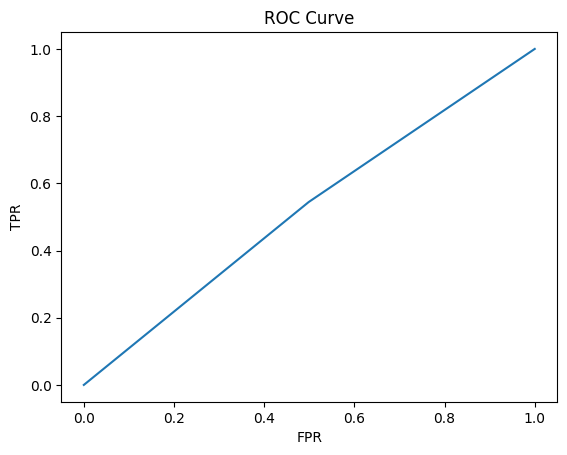

In [23]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [25]:
auc_score= roc_auc_score(Y_true, Y_pred)
print(f"AUC Score: {auc_score}")

AUC Score: 0.5227999999999999
